In [1]:
import pandas as pd
import tensorflow as tf
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input,GlobalAveragePooling1D
from keras import optimizers
import matplotlib.pyplot as plt
import keras_tuner as kt
from datetime import datetime, timedelta
import math

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1955653636530198454
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5729419264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14277076159069212441
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [3]:
timestep = 100
testfrac = 0.25
valfrac = 0.2

In [4]:
start_date = '2020-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
display(end_date)
data = yf.download("AAPL", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dataclose = data['Close']

'2024-01-19'

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
0,74.059998,75.150002,73.797501,75.087502,135480400
1,74.287498,75.144997,74.125000,74.357498,146322800
2,73.447502,74.989998,73.187500,74.949997,118387200
3,74.959999,75.224998,74.370003,74.597504,108872000
4,74.290001,76.110001,74.290001,75.797501,132079200
...,...,...,...,...,...
1013,186.539993,187.050003,183.619995,185.589996,49128400
1014,186.059998,186.740005,185.190002,185.919998,40444700
1015,182.160004,184.259995,180.929993,183.630005,65603000
1016,181.270004,182.929993,180.300003,182.679993,47317400


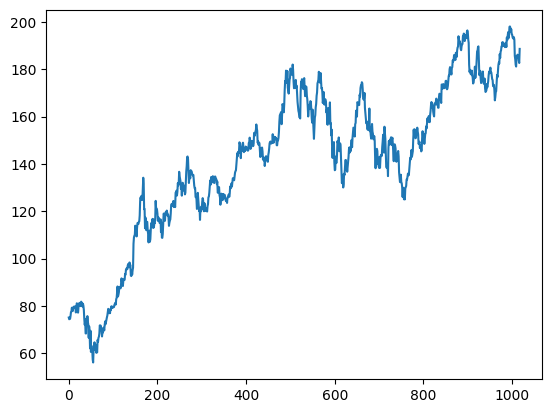

In [5]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
display(data)
plt.plot(dataclose)
plt.show()

In [6]:
Xscaler = MinMaxScaler()
Xdata = Xscaler.fit_transform(np.array(data))
Yscaler = MinMaxScaler()
Ydata = Yscaler.fit_transform(np.array([data['Close']]).transpose()).reshape((Xdata.shape[0],))
display(Xdata.shape)
display(Ydata.shape)

(1018, 5)

(1018,)

In [7]:
X_temp, X_test = train_test_split(Xdata, test_size=testfrac, shuffle=False)
Y_temp, Y_test = train_test_split(Ydata, test_size=testfrac, shuffle=False)
X_train, X_val = train_test_split(X_temp, test_size=valfrac, shuffle=False)
Y_train, Y_val = train_test_split(Y_temp, test_size=valfrac, shuffle=False)


In [8]:
def build_timeseries(Xdata, Ydata, time_step):
    dim_0 = Xdata.shape[0] - time_step
    dim_1 = Xdata.shape[1]

    x = np.zeros((dim_0, time_step, dim_1))
    y = np.zeros((Ydata.shape[0] - time_step,))

    for i in range(dim_0):
        x[i] = Xdata[i:time_step+i]
        y[i] = Ydata[time_step+i]
    return x, y

In [9]:
X_train, Y_train = build_timeseries(X_train, Y_train, timestep)
X_test, Y_test = build_timeseries(X_test, Y_test, timestep)
X_val, Y_val = build_timeseries(X_val, Y_val, timestep)
print("X Train Shape: ", X_train.shape, "   Y Train Shape: ", Y_train.shape)
print("X Val Shape: ", X_val.shape, "   Y Val Shape: ", Y_val.shape)
print("X Test Shape: ", X_test.shape, "   Y Test Shape: ", Y_test.shape)

X Train Shape:  (510, 100, 5)    Y Train Shape:  (510,)
X Val Shape:  (53, 100, 5)    Y Val Shape:  (53,)
X Test Shape:  (155, 100, 5)    Y Test Shape:  (155,)


In [10]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)

(510, 100, 5)

(53, 100, 5)

(155, 100, 5)

In [11]:
def model_builder(hp):
    lstm_model = Sequential()
    
    lstm_units_0 = hp.Int('units_lstm_0', min_value=16, max_value=256, step=16)
    lstm_units_1 = hp.Int('units_lstm_1', min_value=16, max_value=256, step=16)
    lstm_units_2 = hp.Int('units_lstm_2', min_value=16, max_value=256, step=16)
    dense_units_0 = hp.Int('units_dense_0', min_value=16, max_value=128, step=16)
    dense_units_1 = hp.Int('units_dense_1', min_value=16, max_value=128, step=16)
    dense_units_2 = hp.Int('units_dense_2', min_value=16, max_value=128, step=16)
    lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(LSTM(units=lstm_units_0, return_sequences=True))
    lstm_model.add(LSTM(units=lstm_units_1, return_sequences=True))
    lstm_model.add(LSTM(units=lstm_units_2, return_sequences=True))
    lstm_model.add(GlobalAveragePooling1D())
    lstm_model.add(Dense(units=dense_units_0,activation='relu'))
    lstm_model.add(Dense(units=dense_units_1,activation='relu'))
    lstm_model.add(Dropout(0.05))
    lstm_model.add(Dense(units=dense_units_2, activation='linear'))
    lstm_model.add(Dense(units=1))
    lstm_model.summary()
    
    hyperparameters_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.05, 0.1])
    
    lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=hyperparameters_learning_rate))
    
    return lstm_model

In [12]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=50)
tuner.search(X_train, Y_train, epochs=50, validation_data=(X_val,Y_val))
lstm_model  = tuner.get_best_models()[0]  
print(lstm_model.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Trial 50 Complete [00h 00m 28s]
val_loss: 0.0035389133263379335

Best val_loss So Far: 0.0016278636176139116
Total elapsed time: 00h 23m 27s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          68608     
                                                                 
 lstm_1 (LSTM)               (None, 100, 160)          184960    
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          147968    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 80)                10320     
                                               

In [13]:
lstm_model.save("AAPL_LSTM.keras")

In [14]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          68608     
                                                                 
 lstm_1 (LSTM)               (None, 100, 160)          184960    
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          147968    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 80)                10320     
                                                                 
 dense_1 (Dense)             (None, 64)                5184      
                                                        

In [15]:
lstm_model.fit(X_train,Y_train,validation_data = (X_val,Y_val),epochs = 50,batch_size = 64,verbose = 1)

Epoch 1/50
8/8 [==============================] - 4s 140ms/step - loss: 0.0283 - val_loss: 0.0026
Epoch 2/50
8/8 [==============================] - 0s 32ms/step - loss: 0.0279 - val_loss: 0.0034
Epoch 3/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0276 - val_loss: 0.0033
Epoch 4/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0272 - val_loss: 0.0025
Epoch 5/50
8/8 [==============================] - 0s 35ms/step - loss: 0.0267 - val_loss: 0.0021
Epoch 6/50
8/8 [==============================] - 0s 35ms/step - loss: 0.0230 - val_loss: 0.0053
Epoch 7/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0234 - val_loss: 0.0111
Epoch 8/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0235 - val_loss: 0.0090
Epoch 9/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0201 - val_loss: 0.0095
Epoch 10/50
8/8 [==============================] - 0s 35ms/step - loss: 0.0186 - val_loss: 0.0130
Epoch 11/50
8/8 [===========

In [16]:
train_predict = lstm_model.predict(X_train)
val_predict = lstm_model.predict(X_val)
test_predict = lstm_model.predict(X_test)
train_predictraw = Yscaler.inverse_transform(train_predict).reshape((train_predict.shape[0],))
val_predictraw = Yscaler.inverse_transform(val_predict).reshape((val_predict.shape[0],))
test_predictraw = Yscaler.inverse_transform(test_predict).reshape((test_predict.shape[0],))

5/5 [==============================] - 0s 11ms/step


In [17]:
print(Y_test.shape)
print(test_predictraw.shape)

(155,)
(155,)


In [18]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)) / Y_train.shape[0])
print(math.sqrt(mean_squared_error(Y_val,val_predict)) / Y_val.shape[0])
print(math.sqrt(mean_squared_error(Y_test,test_predict)) / Y_test.shape[0])

0.00017557358689382121
0.0028348011798837443
0.0010749951780593201


In [19]:
display(dataclose)
display(pd.DataFrame(test_predictraw))

0        75.087502
1        74.357498
2        74.949997
3        74.597504
4        75.797501
           ...    
1013    185.589996
1014    185.919998
1015    183.630005
1016    182.679993
1017    188.630005
Name: Close, Length: 1018, dtype: float64

,0
0,151.806000
1,153.071884
2,151.937180
3,154.327148
4,156.608292
...,...
150,163.725113
151,164.153763
152,163.985855
153,163.840820


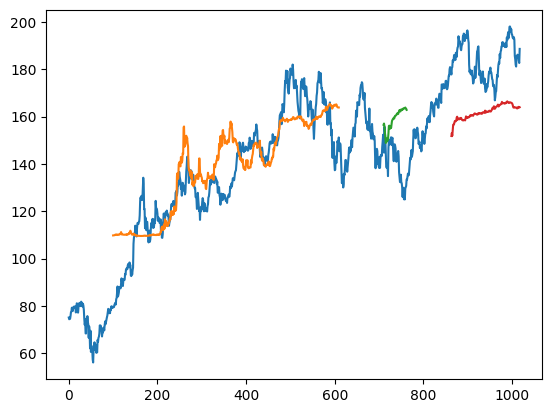

In [20]:
plt.plot(dataclose)

trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot.fill(np.nan)
trainPredictPlot[timestep:len(train_predictraw)+timestep:] = train_predictraw
plt.plot(trainPredictPlot)

valPredictPlot = np.empty_like(dataclose)
valPredictPlot.fill(np.nan)
valPredictPlot[len(train_predictraw)+timestep*2:len(train_predictraw)+timestep*2+len(val_predictraw):] = val_predictraw
plt.plot(valPredictPlot)

testPredictPlot = np.empty_like(dataclose)
testPredictPlot.fill(np.nan)
testPredictPlot[len(train_predictraw)+timestep*3+len(val_predictraw):len(train_predictraw)+timestep*3+len(val_predictraw)+len(test_predictraw):] = test_predictraw
plt.plot(testPredictPlot)

plt.show()